**Import libraries and dataset**

In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
import PIL
from sklearn.model_selection import train_test_split

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/test.csv
/kaggle/input/digit-recognizer/train.csv


In [2]:
ROOT_DIR = '/kaggle/input/digit-recognizer'
train_df = pd.read_csv(os.path.join(ROOT_DIR, 'train.csv'))
test_df = pd.read_csv(os.path.join(ROOT_DIR, 'test.csv'))

In [3]:
print('Train size: {}, test size: {}'.format(train_df.shape, test_df.shape))

Train size: (42000, 785), test size: (28000, 784)


In [4]:
# convert DataFrame to numpy array

feature_train = train_df.to_numpy()[:,1:]
label_train = train_df.to_numpy()[:,0]

feature_test = test_df.to_numpy()

**Split dataset**

In [5]:
feature_train, feature_val, label_train, label_val = train_test_split(feature_train, label_train, test_size=0.2, stratify=label_train)

In [6]:
print('Train size: {}, validation size: {}'.format(len(label_train), len(label_val)))

Train size: 33600, validation size: 8400


In [7]:
feature_train = feature_train.reshape(-1, 28, 28, 1)
feature_val = feature_val.reshape(-1, 28, 28, 1)

feature_test = feature_test.reshape(-1, 28, 28, 1)

In [8]:
# visualize single image
def visualize(image):
    plt.imshow(image[:,:,0], cmap='gray')
    plt.show()
    
# visualize images from different classes
def visualize_samples(input_arr, target_arr, num_classes=10):
    """
    Inputs:
    - input_arr: our features array
    - target_arr: our labels array
    - num_classes: number of classes we want to visualize, default = 10 (maximum).
    """
    assert (num_classes > 0 and num_classes <= 10), 'Number of classes must be in range [1-10]'
    fig, axs = plt.subplots(1, num_classes, figsize=(1.5*num_classes, 2))
    if num_classes == 1:
        axs.imshow(input_arr[target_arr==0][0][:,:,0], cmap='gray')
        axs.axis('off')
        axs.set_title('Digit 0')
    else:
        for i in range(num_classes):
            axs[i].imshow(input_arr[target_arr==i][0][:,:,0], cmap='gray')
            axs[i].axis('off')
            axs[i].set_title('Digit {}'.format(i))

**Given Sample images**

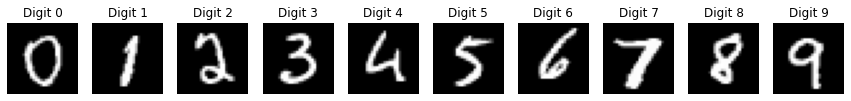

In [9]:
visualize_samples(feature_train, label_train, 10)

In [10]:
# create a generator
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=25,
    height_shift_range=3,
    width_shift_range=3
)

In [11]:
BATCH_SIZE = 64 # use whichever batch size you want

train_ds = train_datagen.flow(feature_train, label_train, batch_size=BATCH_SIZE)  # train_ds is a generator

# val_ds and test_ds are Dataset objects
val_ds = tf.data.Dataset.from_tensor_slices((feature_val, label_val)).batch(BATCH_SIZE).prefetch(1)
test_ds = tf.data.Dataset.from_tensor_slices(feature_test).batch(BATCH_SIZE).prefetch(1)

**Train the model**

In [12]:
layers = [
    tf.keras.layers.Conv2D(32, kernel_size=3, strides=1, padding='same', input_shape=(28,28,1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Conv2D(32, kernel_size=3, strides=1, padding='valid'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Conv2D(32, kernel_size=5, strides=1, padding='valid'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.MaxPool2D(strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(10, activation='softmax')
]

model = tf.keras.Sequential(layers=layers)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(1e-3, decay_steps=3000, decay_rate=0.95)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_ds, epochs=20, validation_data=val_ds)

Epoch 1/20
525/525 [==============================] - 12s 23ms/step - loss: 0.6266 - accuracy: 0.8112 - val_loss: 0.0772 - val_accuracy: 0.9764
Epoch 2/20
525/525 [==============================] - 13s 25ms/step - loss: 0.2215 - accuracy: 0.9316 - val_loss: 0.0716 - val_accuracy: 0.9801
Epoch 3/20
525/525 [==============================] - 12s 23ms/step - loss: 0.1618 - accuracy: 0.9527 - val_loss: 0.0589 - val_accuracy: 0.9837
Epoch 4/20
525/525 [==============================] - 12s 23ms/step - loss: 0.1353 - accuracy: 0.9593 - val_loss: 0.0458 - val_accuracy: 0.9870
Epoch 5/20
525/525 [==============================] - 12s 23ms/step - loss: 0.1254 - accuracy: 0.9622 - val_loss: 0.0461 - val_accuracy: 0.9854
Epoch 6/20
525/525 [==============================] - 12s 23ms/step - loss: 0.1091 - accuracy: 0.9673 - val_loss: 0.0410 - val_accuracy: 0.9877
Epoch 7/20
525/525 [==============================] - 13s 25ms/step - loss: 0.0997 - accuracy: 0.9697 - val_loss: 0.0476 - val_accuracy:

In [13]:
# plot training history of our model
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()


**Plot the learning curves**

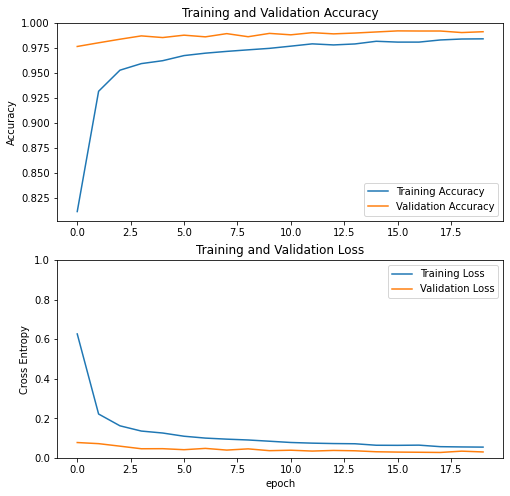

In [14]:
plot_history(history)

**Prediction**

In [17]:
pred_test = np.argmax(model.predict(test_ds), axis=1)
out_df = pd.DataFrame({'ImageId': np.arange(1, len(pred_test)+1), 'Label': pred_test})
out_df.to_csv('digit_recognizer_output.csv', index=False)
print("Output written in csv file")

Output written in csv file
